In [9]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [2]:
import talib
def get_all_indicators(dataframe):
    candles_indicators = dataframe.copy()    
    candles_indicators["rsi"] = talib.RSI(candles_indicators["close"], timeperiod=14)
    candles_indicators["ema_12"] = talib.EMA(candles_indicators["close"], timeperiod=12)
    candles_indicators["ema_26"] = talib.EMA(candles_indicators["close"], timeperiod=26) 

    upper_band, middle_band, lower_band = talib.BBANDS(candles_indicators["close"], timeperiod=20, 
                                                nbdevup=2, nbdevdn=2, matype=0)

    candles_indicators["upper_bband"] = upper_band
    candles_indicators["middle_bband"] = middle_band
    candles_indicators["lower_bband"] = lower_band


    macd, macd_signal, macd_hist = talib.MACD(candles_indicators["close"], fastperiod=12, slowperiod=26, 
                                        signalperiod=9)

    candles_indicators["macd"] = macd 
    candles_indicators["macd_signal"] = macd_signal 
    candles_indicators["macd_hist"] = macd_hist
    
    candles_indicators.dropna(inplace=True)
        
    return candles_indicators

In [41]:
def make_feature_engineering(df):
    
    df['percentage_price_change'] = ((df['close'] - df['close'].shift(1))/df['close'].shift(1))*100
    
    #Date
    df["date"] = pd.to_datetime(df["date"])
    df["hour"] = df["date"].dt.hour
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.weekday
    df["week"] = df["date"].dt.week
    df["month"] = df["date"].dt.month
    df["quarter"] = df["date"].dt.quarter
    df["year"] = df["date"].dt.year
    
    #RSI
    df['discrete_rsi'] = 0
    df.loc[df.rsi >= 70, 'discrete_rsi'] = 1
    df.loc[df.rsi <= 30, 'discrete_rsi'] = -1
    
    #EMA
    df['discrete_ema12_ema26'] = -1
    df.loc[df.ema_12 > df.ema_26, 'discrete_ema12_ema26'] = 1
    
    df['discrete_ema_12'] = 0
    df.loc[df.close > df.ema_12, 'discrete_ema_12'] = 1
    df.loc[df.close < df.ema_12, 'discrete_ema_12'] = -1

    df['discrete_ema_26'] = 0
    df.loc[df.close > df.ema_26, 'discrete_ema_26'] = 1
    df.loc[df.close < df.ema_26, 'discrete_ema_26'] = -1
    
    #Bolinger bands
    df['discrete_bollinger_bands'] = 0
    df.loc[df.close > df.upper_bband, 'discrete_bollinger_bands'] = 1
    df.loc[df.close < df.lower_bband, 'discrete_bollinger_bands'] = -1
    
    #MACD
    df['discrete_macd_signal'] = 0
    df.loc[df.macd_signal > 0, 'discrete_macd_signal'] = 1

    df['discrete_macd_hist'] = 0
    df.loc[df.macd_hist > 0, 'discrete_macd_hist'] = 1

    df['discrete_macd_hist_signal'] = 0
    df.loc[df.macd_hist > df.macd_signal, 'discrete_macd_hist_signal'] = 1
    
    #Candles Features
    df['distance_close_ema_12'] = np.absolute(df['close'] - df['ema_12'])
    df['distance_close_ema_26'] = np.absolute(df['close'] - df['ema_26'])
    df['distance_close_upper_bband'] = np.absolute(df['close'] - df['upper_bband'])
    df['distance_close_middle_bband'] = np.absolute(df['close'] - df['middle_bband'])
    df['distance_close_lower_bband'] = np.absolute(df['close'] - df['lower_bband'])
    
    df['distance_high_low'] = np.absolute(df['high'] - df['low'])
    df['distance_open_close'] = np.absolute(df['open'] - df['close'])
    df['distance_high_open'] = np.absolute(df['high'] - df['open'])
    df['distance_high_close'] = np.absolute(df['high'] - df['close'])
    df['distance_open_low'] = np.absolute(df['open'] - df['low'])
    df['distance_close_low'] = np.absolute(df['close'] - df['low'])
    
    df['bullish_candle'] = 0
    df.loc[df.close > df.open, 'bullish_candle'] = 1

    #Shift
    columns_to_shift = ['percentage_price_change',
                        'discrete_rsi',
                        'discrete_ema12_ema26',
                        'discrete_ema_12',
                        'discrete_ema_26',
                        'discrete_bollinger_bands',
                        'discrete_macd_signal',
                        'discrete_macd_hist',
                        'discrete_macd_hist_signal',
                        'distance_close_ema_12',
                        'distance_close_ema_26',
                        'distance_close_upper_bband',
                        'distance_close_middle_bband',
                        'distance_close_lower_bband',
                        'distance_high_low',
                        'distance_open_close',
                        'distance_high_open',
                        'distance_high_close',
                        'distance_open_low',
                        'distance_close_low',
                        'bullish_candle']
    amount_shift = 5
    
    for column in columns_to_shift:
        for x in range(1, amount_shift + 1):
            new_column = column + '_shifted_' + str(x)
            df[new_column] = df[column].shift(x)
        
    cols = ['date','rsi', 'ema_12', 'ema_26', 'upper_bband', 'middle_bband', 'lower_bband', 'macd', 'macd_signal','macd_hist', 'volume']
    
    df.drop(columns=cols, inplace=True)
    df.dropna(inplace=True)    
    
    return df

In [42]:
def create_target(dataframe):
    dataframe['difference'] = -dataframe['close'].diff(-5)
    
    dataframe.loc[dataframe.difference > 0, 'target'] = 1
    dataframe.loc[dataframe.difference < 0, 'target'] = 0
    
    dataframe.drop(columns='difference', inplace=True)
    
    return dataframe

In [43]:
eur_usd = pd.read_csv('./data/EURUSD.csv')
usd_jpy = pd.read_csv('./data/USDJPY.csv')
gbp_usd = pd.read_csv('./data/GBPUSD.csv')

In [44]:
print(len(eur_usd))
print(len(usd_jpy))
print(len(gbp_usd))

108028
108022
108019


In [48]:
dataframes = [('EURUSD', eur_usd), ('USDJPY', usd_jpy), ('GBPUSD', gbp_usd)]
#dataframes = [('EURUSD', eur_usd)]

In [49]:
new_dataframes = []

for name, df in dataframes:
    df.rename(columns={'Gmt time':'date',
                       'Open':'open',
                       'High':'high',
                       'Low':'low',
                       'Close':'close',
                       'Volume':'volume'}, inplace=True)

    df['date'] = pd.to_datetime(df['date'])
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    df.sort_values('date', inplace=True)
    df.reset_index(inplace=True, drop=True)
    
    df = df.round(4)
    
    df = get_all_indicators(df)
    df = make_feature_engineering(df)
    df = create_target(df)
    df.dropna(inplace=True)
    new_dataframes.append((name, df))

In [51]:
new_dataframes[1][1]

open     high      low    close  percentage_price_change  hour  \
39      120.538  120.679  120.387  120.458                -0.087920    12   
40      120.466  120.634  120.404  120.502                 0.036527    13   
41      120.478  120.483  119.935  119.949                -0.458914    14   
42      119.935  120.082  119.778  119.959                 0.008337    15   
43      119.984  120.053  119.884  119.944                -0.012504    16   
44      119.943  120.058  119.911  119.977                 0.027513    17   
45      119.978  120.071  119.938  120.020                 0.035840    18   
46      119.982  120.069  119.942  120.014                -0.004999    19   
47      116.589  116.675  116.533  116.567                -2.872165     0   
48      116.560  116.637  116.460  116.578                 0.009437     1   
49      116.545  116.667  116.519  116.626                 0.041174     2   
50      116.617  116.720  116.535  116.687                 0.052304     3   
51      116.698  116.739  116.638  116.683                -0.003428     4   
52      116.670  116.716  116.610  116.683                 0.000000     5   
53      116.655  116.775  116.609  116.732                 0.041994     6   
54      116.752  116.763  116.601  116.654                -0.066820     7   
55      116.687  116.731  116.570  116.654                 0.000000     8   
56      116.642  116.690  116.473  116.653                -0.000857     9   
57      116.655  116.671  116.386  116.430                -0.191165    10   
58      116.430  116.472  116.370  116.419                -0.009448    11   
59      116.414  116.476  116.363  116.392                -0.023192    12   
60      116.422  116.450  116.327  116.374                -0.015465    13   
61      116.387  116.510  116.346  116.491                 0.100538    14   
62      116.502  116.612  116.481  116.566                 0.064383    15   
63      116.562  116.599  116.511  116.557                -0.007721    16   
...         ...      ...      ...      ...                      ...   ...   
107992  107.458  107.517  107.431  107.444                -0.012098    18   
107993  107.445  107.463  107.381  107.383                -0.056774    19   
107994  107.382  107.428  107.352  107.405                 0.020487    20   
107995  106.929  106.932  106.899  106.927                -0.445044    21   
107996  106.920  106.936  106.893  106.896                -0.028992    22   
107997  106.897  106.924  106.857  106.918                 0.020581    23   
107998  106.495  106.672  106.460  106.549                -0.345124     0   
107999  106.548  106.671  106.514  106.633                 0.078837     1   
108000  106.634  106.740  106.624  106.717                 0.078775     2   
108001  106.717  106.770  106.674  106.750                 0.030923     3   
108002  106.750  106.800  106.723  106.771                 0.019672     4   
108003  106.772  106.788  106.677  106.718                -0.049639     5   
108004  106.718  106.793  106.695  106.786                 0.063719     6   
108005  106.787  106.820  106.745  106.791                 0.004682     7   
108006  106.790  106.831  106.742  106.808                 0.015919     8   
108007  106.808  106.827  106.747  106.789                -0.017789     9   
108008  106.791  106.890  106.790  106.854                 0.060868    10   
108009  106.854  106.983  106.842  106.948                 0.087971    11   
108010  106.949  107.017  106.761  106.785                -0.152411    12   
108011  106.784  106.826  106.689  106.826                 0.038395    13   
108012  106.826  106.961  106.786  106.892                 0.061783    14   
108013  106.891  106.979  106.852  106.856                -0.033679    15   
108014  106.857  106.918  106.816  106.829                -0.025268    16   
108015  106.830  106.841  106.782  106.819                -0.009361    17   
108016  106.820  106.877  106.807  106.864                 0.042127    18   

      

In [52]:
for name, df in new_dataframes:
    df.to_csv('./data/processed_new_features/{}-processed.csv'.format(name), index=False)

In [53]:
eur_usd, usd_jpy, gbp_usd = new_dataframes

In [54]:
eur_usd = eur_usd[1]
usd_jpy = usd_jpy[1]
gbp_usd = gbp_usd[1]

In [55]:
#dataframes = [('EURUSD', eur_usd), ('USDJPY', usd_jpy), ('GBPUSD', gbp_usd)]
eur_usd['eur_usd'] = 1
eur_usd['usd_jpy'] = 0
eur_usd['gbp_usd'] = 0

usd_jpy['eur_usd'] = 0
usd_jpy['usd_jpy'] = 1
usd_jpy['gbp_usd'] = 0

gbp_usd['eur_usd'] = 0
gbp_usd['usd_jpy'] = 0
gbp_usd['gbp_usd'] = 1

In [56]:
print(len(eur_usd))
print(len(usd_jpy))
print(len(gbp_usd))

105982
107544
106329


In [57]:
display(eur_usd.head(4))
display(usd_jpy.head(4))
display(gbp_usd.head(4))

open    high     low   close  percentage_price_change  hour  day  \
39  1.1166  1.1213  1.1155  1.1179                 0.107459    12    8   
40  1.1179  1.1205  1.1175  1.1192                 0.116289    13    8   
41  1.1196  1.1272  1.1194  1.1251                 0.527162    14    8   
42  1.1251  1.1266  1.1236  1.1252                 0.008888    15    8   

    day_of_week  week  month  quarter  year  discrete_rsi  \
39            2     2      1        1  2003            -1   
40            2     2      1        1  2003            -1   
41            2     2      1        1  2003             0   
42            2     2      1        1  2003             0   

    discrete_ema12_ema26  discrete_ema_12  discrete_ema_26  \
39                    -1               -1               -1   
40                    -1               -1               -1   
41                    -1                1               -1   
42                    -1                1               -1   

    discrete_bollinger_bands  discrete_macd_signal  discrete_macd_hist  \
39                         0                     0                   0   
40                         0                     0                   0   
41                         0                     0                   1   
42                         0                     0                   1   

    discrete_macd_hist_signal  distance_close_ema_12  distance_close_ema_26  \
39                          1               0.005164               0.015214   
40                          1               0.003269               0.012883   
41                          1               0.002226               0.006466   
42                          1               0.001968               0.005895   

    distance_close_upper_bband  distance_close_middle_bband  \
39                    0.050188                     0.015135   
40                    0.045449                     0.011890   
41                    0.035683                     0.004360   
42                    0.031557                     0.002710   

    distance_close_lower_bband  distance_high_low  distance_open_close  \
39                    0.019918             0.0058               0.0013   
40                    0.021669             0.0030               0.0013   
41                    0.026963             0.0078               0.0055   
42                    0.026137             0.0030               0.0001   

    distance_high_open  distance_high_close  distance_open_low  \
39              0.0047               0.0034             0.0011   
40              0.0026               0.0013             0.0004   
41              0.0076               0.0021             0.0002   
42              0.0015               0.0014             0.0015   

    distance_close_low  bullish_candle  percentage_price_change_shifted_1  \
39              0.0024               1                           0.044795   
40              0.0017               1                           0.107459   
41              0.0057               1                           0.116289   
42              0.0016               1                           0.527162   

    percentage_price_change_shifted_2  percentage_price_change_shifted_3  \
39                          -0.134204                           0.224175   
40                           0.044795                          -0.134204   
41                           0.107459                           0.044795   
42                           0.116289                           0.107459   

    percentage_price_change_shifted_4  percentage_price_change_shifted_5  \
39                          -0.481885                           0.000000   
40                           0.224175                          -0.481885   
41                          -0.134204                           0.224175   
42                           0.044795                          -0.134204   

    discrete_rsi_shifted_1  discrete_rsi_shifted_2  discrete_rsi_shifted_3  \
39     

open     high      low    close  percentage_price_change  hour  day  \
39  120.538  120.679  120.387  120.458                -0.087920    12    8   
40  120.466  120.634  120.404  120.502                 0.036527    13    8   
41  120.478  120.483  119.935  119.949                -0.458914    14    8   
42  119.935  120.082  119.778  119.959                 0.008337    15    8   

    day_of_week  week  month  quarter  year  discrete_rsi  \
39            2     2      1        1  2003             0   
40            2     2      1        1  2003             0   
41            2     2      1        1  2003             0   
42            2     2      1        1  2003             0   

    discrete_ema12_ema26  discrete_ema_12  discrete_ema_26  \
39                     1                1                1   
40                     1                1                1   
41                     1               -1               -1   
42                     1               -1               -1   

    discrete_bollinger_bands  discrete_macd_signal  discrete_macd_hist  \
39                         0                     1                   1   
40                         0                     1                   1   
41                         0                     1                   0   
42                         0                     1                   0   

    discrete_macd_hist_signal  distance_close_ema_12  distance_close_ema_26  \
39                          0               0.114008               0.336477   
40                          0               0.133699               0.352293   
41                          0               0.354793               0.185840   
42                          0               0.291748               0.162814   

    distance_close_upper_bband  distance_close_middle_bband  \
39                    0.652118                      0.38030   
40                    0.625157                      0.36695   
41                    1.152321                      0.21320   
42                    1.114135                      0.22915   

    distance_close_lower_bband  distance_high_low  distance_open_close  \
39                    1.412718              0.292                0.080   
40                    1.359057              0.230                0.036   
41                    0.725921              0.548                0.529   
42                    0.655835              0.304                0.024   

    distance_high_open  distance_high_close  distance_open_low  \
39               0.141                0.221              0.151   
40               0.168                0.132              0.062   
41               0.005                0.534              0.543   
42               0.147                0.123              0.157   

    distance_close_low  bullish_candle  percentage_price_change_shifted_1  \
39               0.071               0                           0.056433   
40               0.098               1                          -0.087920   
41               0.014               0                           0.036527   
42               0.181               1                          -0.458914   

    percentage_price_change_shifted_2  percentage_price_change_shifted_3  \
39                           0.147109                          -0.156836   
40                           0.056433                           0.147109   
41                          -0.087920                           0.056433   
42                           0.036527                          -0.087920   

    percentage_price_change_shifted_4  percentage_price_change_shifted_5  \
39                           0.083882                          -0.156722   
40                          -0.156836                           0.083882   
41                           0.147109                          -0.156836   
42                           0.056433                           0.147109   

    discrete_rsi_shifted_1  discrete_rsi_shifted_2  discrete_rsi_s

open    high     low   close  percentage_price_change  hour  day  \
39  1.6029  1.6034  1.6019  1.6034                 0.024953    12    8   
40  1.6036  1.6069  1.6028  1.6061                 0.168392    13    8   
41  1.6062  1.6076  1.6047  1.6055                -0.037358    14    8   
42  1.6059  1.6119  1.6056  1.6078                 0.143258    15    8   

    day_of_week  week  month  quarter  year  discrete_rsi  \
39            2     2      1        1  2003            -1   
40            2     2      1        1  2003             0   
41            2     2      1        1  2003            -1   
42            2     2      1        1  2003             0   

    discrete_ema12_ema26  discrete_ema_12  discrete_ema_26  \
39                    -1               -1               -1   
40                    -1               -1               -1   
41                    -1               -1               -1   
42                    -1               -1               -1   

    discrete_bollinger_bands  discrete_macd_signal  discrete_macd_hist  \
39                         0                     0                   0   
40                         0                     0                   0   
41                         0                     0                   0   
42                         0                     0                   0   

    discrete_macd_hist_signal  distance_close_ema_12  distance_close_ema_26  \
39                          1               0.008357               0.020977   
40                          1               0.004787               0.016923   
41                          1               0.004558               0.016225   
42                          1               0.001911               0.012894   

    distance_close_upper_bband  distance_close_middle_bband  \
39                    0.076277                     0.023215   
40                    0.068927                     0.017730   
41                    0.063960                     0.015465   
42                    0.055105                     0.010395   

    distance_close_lower_bband  distance_high_low  distance_open_close  \
39                    0.029847             0.0015               0.0005   
40                    0.033467             0.0041               0.0025   
41                    0.033030             0.0029               0.0007   
42                    0.034315             0.0063               0.0019   

    distance_high_open  distance_high_close  distance_open_low  \
39              0.0005               0.0000             0.0010   
40              0.0033               0.0008             0.0008   
41              0.0014               0.0021             0.0015   
42              0.0060               0.0041             0.0003   

    distance_close_low  bullish_candle  percentage_price_change_shifted_1  \
39              0.0015               1                           0.006239   
40              0.0033               1                           0.024953   
41              0.0008               0                           0.168392   
42              0.0022               1                          -0.037358   

    percentage_price_change_shifted_2  percentage_price_change_shifted_3  \
39                           0.074920                          -0.242900   
40                           0.006239                           0.074920   
41                           0.024953                           0.006239   
42                           0.168392                           0.024953   

    percentage_price_change_shifted_4  percentage_price_change_shifted_5  \
39                          -0.093336                          -0.031102   
40                          -0.242900                          -0.093336   
41                           0.074920                          -0.242900   
42                           0.006239                           0.074920   

    discrete_rsi_shifted_1  discrete_rsi_shifted_2  discrete_rsi_shifted_3  \
39     

In [58]:
df_full = pd.concat([eur_usd, usd_jpy, gbp_usd], ignore_index=True)

In [59]:
len(df_full)

319855

In [60]:
df_full.to_csv('./data/processed_new_features/full_df.csv', index=False)

In [61]:
df_full

open    high     low   close  percentage_price_change  hour  day  \
0       1.1166  1.1213  1.1155  1.1179                 0.107459    12    8   
1       1.1179  1.1205  1.1175  1.1192                 0.116289    13    8   
2       1.1196  1.1272  1.1194  1.1251                 0.527162    14    8   
3       1.1251  1.1266  1.1236  1.1252                 0.008888    15    8   
4       1.1245  1.1259  1.1245  1.1254                 0.017775    16    8   
5       1.1249  1.1252  1.1239  1.1243                -0.097743    17    8   
6       1.1242  1.1256  1.1241  1.1254                 0.097839    18    8   
7       1.1243  1.1256  1.1241  1.1254                 0.000000    19    8   
8       1.0990  1.0992  1.0976  1.0978                -2.452461     0    9   
9       1.0974  1.0983  1.0970  1.0981                 0.027327     1    9   
10      1.0982  1.0990  1.0974  1.0987                 0.054640     2    9   
11      1.0988  1.1003  1.0985  1.0994                 0.063712     3    9   
12      1.0994  1.0997  1.0983  1.0983                -0.100055     4    9   
13      1.0985  1.1014  1.0984  1.1004                 0.191205     5    9   
14      1.1007  1.1013  1.0991  1.0992                -0.109051     6    9   
15      1.0992  1.0993  1.0970  1.0976                -0.145560     7    9   
16      1.0979  1.0989  1.0976  1.0982                 0.054665     8    9   
17      1.0980  1.0986  1.0974  1.0979                -0.027317     9    9   
18      1.0980  1.0988  1.0973  1.0978                -0.009108    10    9   
19      1.0980  1.0985  1.0957  1.0964                -0.127528    11    9   
20      1.0962  1.0979  1.0952  1.0975                 0.100328    12    9   
21      1.0976  1.0984  1.0971  1.0974                -0.009112    13    9   
22      1.0974  1.0976  1.0964  1.0970                -0.036450    14    9   
23      1.0970  1.0978  1.0955  1.0964                -0.054695    15    9   
24      1.0961  1.0973  1.0956  1.0962                -0.018242    16    9   
...        ...     ...     ...     ...                      ...   ...  ...   
319830  1.2525  1.2527  1.2503  1.2504                -0.167665    16    6   
319831  1.2504  1.2509  1.2475  1.2485                -0.151951    17    6   
319832  1.2485  1.2492  1.2474  1.2491                 0.048058    18    6   
319833  1.2491  1.2523  1.2491  1.2520                 0.232167    19    6   
319834  1.2520  1.2551  1.2520  1.2542                 0.175719    20    6   
319835  1.2642  1.2654  1.2629  1.2632                 0.717589    21    7   
319836  1.2632  1.2639  1.2627  1.2637                 0.039582    22    7   
319837  1.2638  1.2638  1.2627  1.2627                -0.079133    23    7   
319838  1.3052  1.3060  1.3037  1.3047                 3.326206     0    8   
319839  1.3047  1.3056  1.3031  1.3037                -0.076646     1    8   
319840  1.3037  1.3042  1.3021  1.3029                -0.061364     2    8   
319841  1.3029  1.3033  1.3022  1.3027                -0.015350     3    8   
319842  1.3027  1.3030  1.3018  1.3022                -0.038382     4    8   
319843  1.3022  1.3037  1.3017  1.3036                 0.107510     5    8   
319844  1.3036  1.3054  1.3032  1.3039                 0.023013     6    8   
319845  1.3039  1.3054  1.3035  1.3050                 0.084362     7    8   
319846  1.3050  1.3068  1.3046  1.3054                 0.030651     8    8   
319847  1.3054  1.3066  1.3047  1.3051                -0.022981     9    8   
319848  1.3047  1.3048  1.3007  1.3018                -0.222273    11    8   
319849  1.3018  1.3044  1.3006  1.3038                 0.153633    12    8   
319850  1.3038  1.3057  1.3027  1.3028                -0.076699    13    8   
319851  1.3028  1.3060  1.3014  1.3058                 0.230273    14    8   
319852  1.3058  1.3058  1.3040  1.3047                -0.084240    15    8   
319853  1.3047  1.3056  1.3039  1.3045                -0.015329    16    8   
319854  1.3037  1.3039  1.3026  

In [35]:
test = df_full.loc[(df_full['year'] == 2020) & (df_full['month'] == 8) & (df_full['day'] == 18)]
test

open       high        low      close  percentage_price_change  \
107201    1.18749    1.18920    1.18744    1.18910                 0.134737   
107202    1.18908    1.18969    1.18835    1.18898                -0.010092   
107203    1.18897    1.18950    1.18865    1.18894                -0.003364   
107204    1.18896    1.18926    1.18857    1.18861                -0.027756   
107205    1.18863    1.18954    1.18862    1.18921                 0.050479   
107206    1.18924    1.18957    1.18891    1.18924                 0.002523   
107207    1.18924    1.19043    1.18837    1.18859                -0.054657   
107208    1.18855    1.19060    1.18828    1.18935                 0.063941   
107209    1.18934    1.19154    1.18863    1.19106                 0.143776   
107210    1.19106    1.19128    1.19014    1.19034                -0.060450   
107211    1.19035    1.19099    1.18975    1.19012                -0.018482   
107212    1.19008    1.19081    1.18978    1.19068                 0.047054   
107213    1.19068    1.19450    1.19043    1.19366                 0.250277   
107214    1.19366    1.19660    1.19356    1.19582                 0.180956   
107215    1.19582    1.19612    1.19191    1.19209                -0.311920   
107216    1.19210    1.19326    1.19181    1.19280                 0.059559   
107217    1.19279    1.19386    1.19223    1.19362                 0.068746   
107218    1.19364    1.19384    1.19299    1.19320                -0.035187   
107219    1.19319    1.19389    1.19285    1.19382                 0.051961   
107220    1.19382    1.19385    1.19306    1.19334                -0.040207   
107221    1.19335    1.19384    1.19296    1.19317                -0.014246   
107222    1.19317    1.19350    1.19306    1.19327                 0.008381   
214746  106.00600  106.00900  105.75200  105.76300                -0.230173   
214747  105.76500  105.82900  105.70500  105.73300                -0.028365   
214748  105.73400  105.74400  105.63600  105.64900                -0.079445   
...           ...        ...        ...        ...                      ...   
214765  105.40800  105.44300  105.36800  105.38300                -0.022769   
214766  105.38300  105.41700  105.37600  105.41300                 0.028468   
214767  105.41300  105.48900  105.39600  105.42900                 0.015178   
322450    1.31069    1.31336    1.31061    1.31332                 0.199893   
322451    1.31323    1.31379    1.31233    1.31299                -0.025127   
322452    1.31297    1.31362    1.31267    1.31293                -0.004570   
322453    1.31295    1.31314    1.31254    1.31294                 0.000762   
322454    1.31295    1.31379    1.31294    1.31365                 0.054077   
322455    1.31366    1.31452    1.31340    1.31371                 0.004567   
322456    1.31372    1.31684    1.31356    1.31531                 0.121792   
322457    1.31531    1.31707    1.31502    1.31575                 0.033452   
322458    1.31575    1.31754    1.31520    1.31695                 0.091203   
322459    1.31696    1.31757    1.31622    1.31727                 0.024299   
322460    1.31727    1.31807    1.31596    1.31619                -0.081988   
322461    1.31616    1.31792    1.31539    1.31784                 0.125362   
322462    1.31784    1.31999    1.31727    1.31953                 0.128240   
322463    1.31956    1.32412    1.31894    1.32292                 0.256910   
322464    1.32296    1.32384    1.32056    1.32184                -0.081638   
322465    1.32185    1.32327    1.32107    1.32267                 0.062791   
322466    1.32267    1.32373    1.32231    1.32350                 0.062752   
322467    1.32353    1.32451    1.32326    1.32371                 0.015867   
322468    1.32372    1.32450    1.32342    1.32444                 0.055148   
322469    1.32442    1.32505    1.32385    1.32403                -0.030956   
322470    1.32402    1.32455    1.32382    1.32404             

In [36]:
len(test)

66

In [37]:
train = pd.concat([df_full, test]).drop_duplicates(keep=False)

In [38]:
len(train)

322931

In [39]:
323096 - 66

323030

In [42]:
train = train.reindex(np.random.permutation(train.index))
train

open       high        low      close  percentage_price_change  \
235544    1.74458    1.74595    1.74451    1.74507                 0.022927   
184867  119.95400  120.09100  119.91300  120.06100                 0.090035   
97513     1.13953    1.14121    1.13946    1.14026                 0.064061   
229823    1.85852    1.85903    1.85538    1.85647                -0.113528   
166597   79.14500   79.15800   78.99800   79.10300                -0.053067   
173533  102.13800  102.15900  102.04600  102.10900                -0.028393   
62040     1.35535    1.35581    1.35474    1.35579                 0.033940   
86944     1.18498    1.18597    1.18489    1.18560                 0.050633   
82424     1.10156    1.10171    1.10047    1.10077                -0.071716   
184345  119.59300  119.92000  119.54200  119.76900                 0.147166   
42135     1.39631    1.39706    1.39533    1.39604                -0.027212   
184104  123.17400  123.19300  123.10800  123.11700                -0.046276   
184033  121.10200  121.18500  120.99200  121.05100                -0.042939   
17925     1.21757    1.21768    1.21704    1.21714                -0.036137   
185079  121.94200  121.94800  121.74000  121.78000                -0.132031   
295940    1.41480    1.41656    1.41456    1.41578                 0.068560   
278596    1.53401    1.53403    1.53337    1.53352                -0.031942   
3311      1.12094    1.12120    1.11967    1.11998                -0.081185   
150325   85.83500   85.84000   85.73900   85.80000                -0.040776   
97569     1.13934    1.14002    1.13887    1.13944                 0.007899   
171851   97.39000   97.53200   97.37900   97.49500                 0.110898   
16095     1.32770    1.32782    1.32685    1.32735                -0.021843   
142308   96.43000   96.54000   96.25500   96.46000                 0.015553   
113834  109.42300  109.57700  109.37600  109.53000                 0.089553   
173600   94.23100   94.31700   94.19200   94.23900                 0.011674   
...           ...        ...        ...        ...                      ...   
213669  105.19500  105.55700  105.16000  105.49900                 0.288987   
200239  105.81700  105.82800  105.69400  105.71100                -0.101117   
135463  116.64000  116.67500  116.38500  116.43500                -0.175754   
215755    1.68230    1.68278    1.68070    1.68113                -0.066578   
150248   88.75000   88.88000   88.53000   88.53000                -0.247887   
151241   91.89500   92.12500   91.86000   91.93000                 0.038087   
162689   76.24200   76.28700   76.21400   76.26900                 0.035414   
22534     1.32690    1.32739    1.32629    1.32697                 0.000000   
303815    1.30607    1.30761    1.30596    1.30754                 0.114851   
3428      1.17373    1.17640    1.17314    1.17560                 0.152495   
100117    1.12073    1.12126    1.12072    1.12122                 0.044614   
219524    1.80308    1.80367    1.80283    1.80323                 0.000000   
320716    1.23107    1.23210    1.23047    1.23095                -0.010560   
146311   93.02000   93.03000   92.82000   92.98500                -0.042999   
113848  109.27800  109.41800  109.11900  109.35000                 0.086036   
25578     1.36969    1.37010    1.36804    1.36852                -0.088339   
306785    1.30372    1.30451    1.30371    1.30398                 0.019943   
268010    1.57457    1.57521    1.57431    1.57475                 0.011432   
203428  112.28800  112.34900  112.17500  112.32600                 0.032951   
204311  113.99800  114.04500  113.97400  113.99000                -0.005263   
128476  116.94900  117.03000  116.93000  117.01000                 0.048738   
278136    1.52301    1.52360    1.52259    1.52319                 0.012475   
247731    1.99940    2.00040    1.99760    1.99780                -0.080024   
200748  107.28300  107.32500  107.24800  107.27500             

In [43]:
train.to_csv('./data/processed_new_features/train.csv', index=False)
test.to_csv('./data/processed_new_features/test.csv',index=False)

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [8]:
full_df = pd.read_csv('./data/processed_new_features/full_df.csv')

In [9]:
train, test = train_test_split(full_df, train_size=0.8, random_state=42)
del full_df

In [10]:
train.drop(columns=['open','high','low','close'], inplace=True)
test.drop(columns=['open','high','low','close'], inplace=True)
train.head(4)

percentage_price_change  hour  day  day_of_week  week  month  quarter  \
180                   -0.008345     5   12            2     7      2        1   
25401                 -0.067094     7   22            4    25      6        2   
293446                 0.006829     3   29            4    17      4        2   
41638                 -0.293710    17    6            5     5      2        1   

        year  discrete_rsi  discrete_ema12_ema26  discrete_ema_12  \
180     2003             1                     1                1   
25401   2007             0                     1                1   
293446  2016             0                     1                1   
41638   2010            -1                    -1               -1   

        discrete_ema_26  discrete_bollinger_bands  discrete_macd_signal  \
180                   1                         0                     1   
25401                 1                         0                     0   
293446                1                         0                     1   
41638                -1                         0                     0   

        discrete_macd_hist  discrete_macd_hist_signal  distance_close_ema_12  \
180                      1                          0               0.012455   
25401                    1                          1               0.000808   
293446                   1                          0               0.002445   
41638                    1                          1               0.005834   

        distance_close_ema_26  distance_close_upper_bband  \
180                  0.025406                    0.006892   
25401                0.000884                    0.000379   
293446               0.004482                    0.001412   
41638                0.031832                    0.076836   

        distance_close_middle_bband  distance_close_lower_bband  \
180                        0.021730                    0.050352   
25401                      0.001065                    0.002509   
293446                     0.004375                    0.010162   
41638                      0.011125                    0.054586   

        distance_high_low  distance_open_close  distance_high_open  \
180                0.0011               0.0003              0.0005   
25401              0.0009               0.0009              0.0000   
293446             0.0013               0.0001              0.0009   
41638              0.0049               0.0035              0.0008   

        distance_high_close  distance_open_low  distance_close_low  \
180                  0.0008             0.0006              0.0003   
25401                0.0009             0.0009              0.0000   
293446               0.0008             0.0004              0.0005   
41638                0.0043             0.0041              0.0006   

        bullish_candle  percentage_price_change_shifted_1  \
180                  0                          -0.008344   
25401                0                           0.104478   
293446               1                          -0.020483   
41638                0                           0.434284   

        percentage_price_change_shifted_2  percentage_price_change_shifted_3  \
180                              0.058445                           0.016701   
25401                            0.044796                           0.007467   
293446                           0.102522                           0.136883   
41638                            0.040987                           0.032800   

        percentage_price_change_shifted_4  percentage_price_change_shifted_5  \
180                              0.091942                           3.316062   
25401                            0.029875                           0.037358   
293446                           0.013690                          -0.013688   
41638                            0.106715                          -0.302807   

        discrete_rsi_shifte

In [11]:
len(train.columns)

137

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train = train.drop(columns='target')
y_train = train['target']

scaled_features = scaler.fit_transform(x_train)
x_train = pd.DataFrame(scaled_features, index=x_train.index, columns=x_train.columns)

x_test = test.drop(columns='target')
y_test = test['target']

scaled_features = scaler.fit_transform(x_test)
x_test = pd.DataFrame(scaled_features, index=x_test.index, columns=x_test.columns)

In [21]:
train.drop(columns=['open','high','low','close'], inplace=True)
test.drop(columns=['open','high','low','close'], inplace=True)
train.head(4)

percentage_price_change  hour  day  day_of_week  week  month  quarter  \
0                 0.022927     2    2            2    31      8        3   
1                 0.090035     6   24            3    39      9        3   
2                 0.064061    10   24            0    52     12        4   
3                -0.113528     6    2            4    35      9        3   

   year  discrete_rsi  discrete_ema12_ema26  discrete_ema_12  discrete_ema_26  \
0  2006            -1                    -1               -1               -1   
1  2015             0                    -1               -1               -1   
2  2018             0                    -1                1                1   
3  2005             1                     1                1                1   

   discrete_bollinger_bands  discrete_macd_signal  discrete_macd_hist  \
0                         0                     0                   0   
1                         0                     0                   0   
2                         0                     0                   1   
3                         0                     1                   1   

   discrete_macd_hist_signal  percentage_price_change_shifted_1  \
0                          0                           0.013758   
1                          0                          -0.067481   
2                          1                          -0.036844   
3                          0                           0.239464   

   percentage_price_change_shifted_2  percentage_price_change_shifted_3  \
0                          -1.362156                           0.046388   
1                          -0.005831                           0.079202   
2                           0.190722                          -0.028117   
3                           0.045325                           0.028606   

   percentage_price_change_shifted_4  percentage_price_change_shifted_5  \
0                          -5.346577                          -0.010173   
1                          -0.211314                           0.034954   
2                          -0.088666                          -0.008778   
3                           0.020514                          -0.073904   

   discrete_rsi_shifted_1  discrete_rsi_shifted_2  discrete_rsi_shifted_3  \
0                    -1.0                    -1.0                    -1.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     1.0                     1.0                     1.0   

   discrete_rsi_shifted_4  discrete_rsi_shifted_5  \
0                    -1.0                     0.0   
1                     0.0                     0.0   
2                     0.0                     0.0   
3                     1.0                     1.0   

   discrete_ema12_ema26_Shifted_1  discrete_ema12_ema26_Shifted_2  \
0                            -1.0                            -1.0   
1                            -1.0                            -1.0   
2                            -1.0                            -1.0   
3                             1.0                             1.0   

   discrete_ema12_ema26_Shifted_3  discrete_ema12_ema26_Shifted_4  \
0                            -1.0                            -1.0   
1                            -1.0                             1.0   
2                            -1.0                            -1.0   
3                             1.0                             1.0   

   discrete_ema12_ema26_Shifted_5  discrete_ema_12_shifted_1  \
0                             1.0                       -1.0   
1                             1.0                       -1.0   
2                            -1.0                        1.0   
3                             1.0                        1.0   

   discrete_ema_12_shifted_2  discrete_ema_12_shifted_3  \
0                       -1.0          

In [22]:
len(train.columns)

60

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train = train.drop(columns='target')
y_train = train['target']

scaled_features = scaler.fit_transform(x_train)
x_train = pd.DataFrame(scaled_features, index=x_train.index, columns=x_train.columns)

x_test = test.drop(columns='target')
y_test = test['target']

scaled_features = scaler.fit_transform(x_test)
x_test = pd.DataFrame(scaled_features, index=x_test.index, columns=x_test.columns)

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [14]:
model = Sequential()
model.add(Dense(256, input_dim=136, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(1,activation = "sigmoid")) 

model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])

In [2]:
full_df = pd.read_csv('./data/processed_new_features/zz.csv')
test = pd.read_csv('./data/processed_new_features/test.csv')

FileNotFoundError: File b'./data/processed_new_features/train.csv' does not exist

In [15]:
x_test.describe()

percentage_price_change          hour           day   day_of_week  \
count             63971.000000  63971.000000  63971.000000  63971.000000   
mean                  0.320065      0.499076      0.490921      0.400937   
std                   0.011387      0.300638      0.292106      0.295544   
min                   0.000000      0.000000      0.000000      0.000000   
25%                   0.318929      0.217391      0.233333      0.166667   
50%                   0.319939      0.478261      0.500000      0.333333   
75%                   0.320951      0.739130      0.733333      0.666667   
max                   1.000000      1.000000      1.000000      1.000000   

               week         month       quarter          year  discrete_rsi  \
count  63971.000000  63971.000000  63971.000000  63971.000000   63971.00000   
mean       0.494096      0.504615      0.505661      0.498770       0.50197   
std        0.287565      0.311391      0.370133      0.294059       0.27349   
min        0.000000      0.000000      0.000000      0.000000       0.00000   
25%        0.250000      0.272727      0.333333      0.235294       0.50000   
50%        0.500000      0.545455      0.666667      0.470588       0.50000   
75%        0.750000      0.818182      1.000000      0.764706       0.50000   
max        1.000000      1.000000      1.000000      1.000000       1.00000   

       discrete_ema12_ema26  discrete_ema_12  discrete_ema_26  \
count          63971.000000     63971.000000     63971.000000   
mean               0.506948         0.504932         0.506042   
std                0.499956         0.499980         0.499967   
min                0.000000         0.000000         0.000000   
25%                0.000000         0.000000         0.000000   
50%                1.000000         1.000000         1.000000   
75%                1.000000         1.000000         1.000000   
max                1.000000         1.000000         1.000000   

       discrete_bollinger_bands  discrete_macd_signal  discrete_macd_hist  \
count              63971.000000          63971.000000        63971.000000   
mean                   0.501172              0.507699            0.502337   
std                    0.187269              0.499945            0.499998   
min                    0.000000              0.000000            0.000000   
25%                    0.500000              0.000000            0.000000   
50%                    0.500000              1.000000            1.000000   
75%                    0.500000              1.000000            1.000000   
max                    1.000000              1.000000            1.000000   

       discrete_macd_hist_signal  distance_close_ema_12  \
count               63971.000000           63971.000000   
mean                    0.494068               0.008737   
std                     0.499969               0.032888   
min                     0.000000               0.000000   
25%                     0.000000               0.000081   
50%                     0.000000               0.000304   
75%                     1.000000               0.004175   
max                     1.000000               1.000000   

       distance_close_ema_26  distance_close_upper_bband  \
count           63971.000000                63971.000000   
mean                0.015212                    0.013189   
std                 0.046569                    0.045092   
min                 0.000000                    0.000000   
25%                 0.000165                    0.000125   
50%                 0.000647                    0.000491   
75%                 0.007729                    0.006274   
max                 1.000000                    1.000000   

       distance_close_middle_bband  distance_close_lower_bband  \
count                 63971.000000                63971.000000   
mean                      0.013212                    0.015775   
std                       0.044694                    0.053

In [14]:
display(x_train.head(5))
display(x_test.head(5))
display(y_train.head(5))
display(y_test.head(5))

percentage_price_change      hour       day  day_of_week      week  \
0                 0.310804  0.086957  0.033333     0.333333  0.576923   
1                 0.312054  0.260870  0.766667     0.500000  0.730769   
2                 0.311570  0.434783  0.766667     0.000000  0.980769   
3                 0.308263  0.260870  0.033333     0.666667  0.653846   
4                 0.309389  0.304348  0.566667     0.500000  0.788462   

      month   quarter      year  discrete_rsi  discrete_ema12_ema26  \
0  0.636364  0.666667  0.176471           0.0                   0.0   
1  0.727273  0.666667  0.705882           0.5                   0.0   
2  1.000000  1.000000  0.882353           0.5                   0.0   
3  0.727273  0.666667  0.117647           1.0                   1.0   
4  0.818182  1.000000  0.529412           0.5                   1.0   

   discrete_ema_12  discrete_ema_26  discrete_bollinger_bands  \
0              0.0              0.0                       0.5   
1              0.0              0.0                       0.5   
2              1.0              1.0                       0.5   
3              1.0              1.0                       0.5   
4              1.0              1.0                       0.5   

   discrete_macd_signal  discrete_macd_hist  discrete_macd_hist_signal  \
0                   0.0                 0.0                        0.0   
1                   0.0                 0.0                        0.0   
2                   0.0                 1.0                        1.0   
3                   1.0                 1.0                        0.0   
4                   1.0                 1.0                        0.0   

   percentage_price_change_shifted_1  percentage_price_change_shifted_2  \
0                           0.310633                           0.285008   
1                           0.309120                           0.310268   
2                           0.309691                           0.313929   
3                           0.314837                           0.311221   
4                           0.310518                           0.309648   

   percentage_price_change_shifted_3  percentage_price_change_shifted_4  \
0                           0.311241                           0.210801   
1                           0.311852                           0.306441   
2                           0.309853                           0.308726   
3                           0.310910                           0.310759   
4                           0.310824                           0.309601   

   percentage_price_change_shifted_5  discrete_rsi_shifted_1  \
0                           0.310187                     0.0   
1                           0.311028                     0.5   
2                           0.310213                     0.5   
3                           0.309000                     1.0   
4                           0.311459                     0.5   

   discrete_rsi_shifted_2  discrete_rsi_shifted_3  discrete_rsi_shifted_4  \
0                     0.0                     0.0                     0.0   
1                     0.5                     0.5                     0.5   
2                     0.5                     0.5                     0.5   
3                     1.0                     1.0                     1.0   
4                     0.5                     0.5                     0.5   

   discrete_rsi_shifted_5  discrete_ema12_ema26_Shifted_1  \
0                     0.5                             0.0   
1                     0.5                             0.0   
2                     0.5                             0.0   
3                     1.0                             1.0   
4                     1.0                             1.0   

   discrete_ema12_ema26_Shifted_2  discrete_ema12_ema26_Shifted_3  \
0                             0.0                             0.0   
1                             0.0             

open          high       low         close  percentage_price_change  \
0  0.000000  0.000000e+00  0.000000  4.876910e-06                 0.785221   
1  0.000015  4.674689e-06  0.000009  3.729402e-06                 0.530613   
2  0.000014  2.862055e-06  0.000012  3.346899e-06                 0.542440   
3  0.000014  5.724109e-07  0.000011  1.912514e-07                 0.499559   
4  0.000011  3.243662e-06  0.000011  5.928793e-06                 0.637096   

       hour  day  day_of_week  week  month  quarter  year  discrete_rsi  \
0  0.000000  0.0          0.0   0.0    0.0      0.0   0.0           1.0   
1  0.047619  0.0          0.0   0.0    0.0      0.0   0.0           0.5   
2  0.095238  0.0          0.0   0.0    0.0      0.0   0.0           0.5   
3  0.142857  0.0          0.0   0.0    0.0      0.0   0.0           0.5   
4  0.190476  0.0          0.0   0.0    0.0      0.0   0.0           0.5   

   discrete_ema12_ema26  discrete_ema_12  discrete_ema_26  \
0                   1.0              1.0              1.0   
1                   1.0              1.0              1.0   
2                   1.0              1.0              1.0   
3                   1.0              1.0              1.0   
4                   1.0              1.0              1.0   

   discrete_bollinger_bands  discrete_macd_signal  discrete_macd_hist  \
0                       1.0                   1.0                 1.0   
1                       0.0                   1.0                 1.0   
2                       0.0                   1.0                 1.0   
3                       0.0                   1.0                 1.0   
4                       0.0                   1.0                 1.0   

   discrete_macd_hist_signal  percentage_price_change_shifted_1  \
0                        0.0                           0.577967   
1                        0.0                           0.785221   
2                        0.0                           0.530613   
3                        0.0                           0.542440   
4                        0.0                           0.499559   

   percentage_price_change_shifted_2  percentage_price_change_shifted_3  \
0                           0.515785                           0.609071   
1                           0.577967                           0.515785   
2                           0.785221                           0.577967   
3                           0.530613                           0.785221   
4                           0.542440                           0.530613   

   percentage_price_change_shifted_4  percentage_price_change_shifted_5  \
0                           0.543911                           0.625393   
1                           0.609071                           0.543911   
2                           0.515785                           0.609071   
3                           0.577967                           0.515785   
4                           0.785221                           0.577967   

   discrete_rsi_shifted_1  discrete_rsi_shifted_2  discrete_rsi_shifted_3  \
0                     0.5                     0.5                     0.5   
1                     1.0                     0.5                     0.5   
2                     0.5                     1.0                     0.5   
3                     0.5                     0.5                     1.0   
4                     0.5                     0.5                     0.5   

   discrete_rsi_shifted_4  discrete_rsi_shifted_5  \
0                     0.5                     0.5   
1                     0.5                     0.5   
2                     0.5                     0.5   
3                     0.5                     0.5   
4                     1.0                     0.5   

   discrete_ema12_ema26_Shifted_1  discrete_ema12_ema26_Shifted_2  \
0                             1.0                             1.0   
1                             1.0                       

0    0.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: target, dtype: float64

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: target, dtype: float64

## 1 epoca

7997/7997 [==============================] - 38s 5ms/step - loss: 0.6934 - accuracy: 0.5071 - val_loss: 0.6928 - val_accuracy: 0.5126


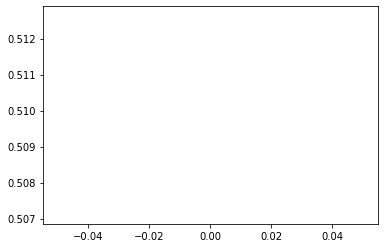

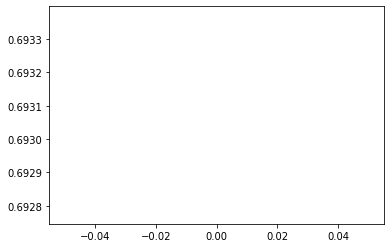

In [16]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=1,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## 2 epocas

Epoch 1/2
7997/7997 [==============================] - 38s 5ms/step - loss: 0.6928 - accuracy: 0.5110 - val_loss: 0.6923 - val_accuracy: 0.5169
Epoch 2/2
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6926 - accuracy: 0.5117 - val_loss: 0.6923 - val_accuracy: 0.5194


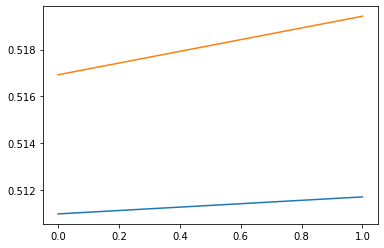

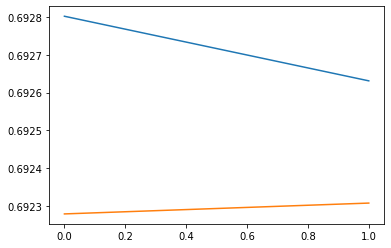

In [17]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=2,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## 4 epocas

Epoch 1/4
10092/10092 [==============================] - 37s 4ms/step - loss: 0.6924 - accuracy: 0.5157 - val_loss: 0.6920 - val_accuracy: 0.5455
Epoch 2/4
10092/10092 [==============================] - 37s 4ms/step - loss: 0.6923 - accuracy: 0.5142 - val_loss: 0.6878 - val_accuracy: 0.3939
Epoch 3/4
10092/10092 [==============================] - 37s 4ms/step - loss: 0.6922 - accuracy: 0.5156 - val_loss: 0.6922 - val_accuracy: 0.4091
Epoch 4/4
10092/10092 [==============================] - 37s 4ms/step - loss: 0.6921 - accuracy: 0.5179 - val_loss: 0.6884 - val_accuracy: 0.3485


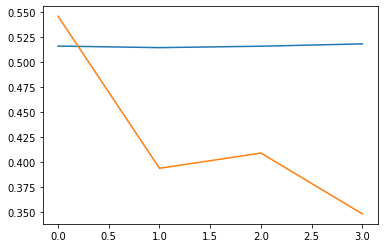

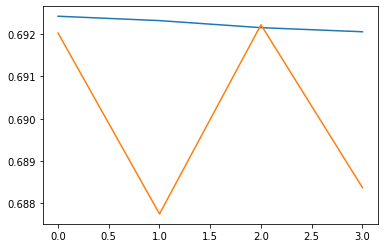

In [25]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=4,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## 8 epocas

Epoch 1/8
7997/7997 [==============================] - 36s 5ms/step - loss: 0.6925 - accuracy: 0.5130 - val_loss: 0.6920 - val_accuracy: 0.5161
Epoch 2/8
7997/7997 [==============================] - 36s 5ms/step - loss: 0.6923 - accuracy: 0.5150 - val_loss: 0.6922 - val_accuracy: 0.5177
Epoch 3/8
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6922 - accuracy: 0.5157 - val_loss: 0.6918 - val_accuracy: 0.5174
Epoch 4/8
7997/7997 [==============================] - 36s 5ms/step - loss: 0.6922 - accuracy: 0.5154 - val_loss: 0.6921 - val_accuracy: 0.5145
Epoch 5/8
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6920 - accuracy: 0.5177 - val_loss: 0.6920 - val_accuracy: 0.5145
Epoch 6/8
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6920 - accuracy: 0.5173 - val_loss: 0.6917 - val_accuracy: 0.5170
Epoch 7/8
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6919 - accuracy: 0.5177 - val_loss: 0.6915 - val_accuracy:

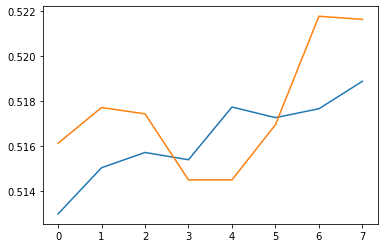

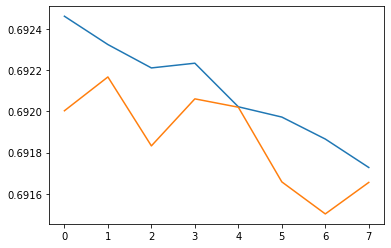

In [18]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=8,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## 16 epocas

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Epoch 1/16
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6861 - accuracy: 0.5339 - val_loss: 0.6940 - val_accuracy: 0.5220
Epoch 2/16
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6861 - accuracy: 0.5344 - val_loss: 0.6929 - val_accuracy: 0.5272
Epoch 3/16
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6863 - accuracy: 0.5343 - val_loss: 0.6919 - val_accuracy: 0.5286
Epoch 4/16
7997/7997 [==============================] - 39s 5ms/step - loss: 0.6859 - accuracy: 0.5363 - val_loss: 0.6936 - val_accuracy: 0.5233
Epoch 5/16
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6858 - accuracy: 0.5348 - val_loss: 0.6962 - val_accuracy: 0.5245
Epoch 6/16
1987/7997 [======>.......................] - ETA: 25s - loss: 0.6850 - accuracy: 0.5384

## 32 epocas

Epoch 1/32
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6904 - accuracy: 0.5238 - val_loss: 0.6913 - val_accuracy: 0.5227
Epoch 2/32
7997/7997 [==============================] - 36s 5ms/step - loss: 0.6902 - accuracy: 0.5261 - val_loss: 0.6916 - val_accuracy: 0.5233
Epoch 3/32
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6901 - accuracy: 0.5243 - val_loss: 0.6918 - val_accuracy: 0.5204
Epoch 4/32
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6897 - accuracy: 0.5270 - val_loss: 0.6916 - val_accuracy: 0.5210
Epoch 5/32
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6898 - accuracy: 0.5279 - val_loss: 0.6915 - val_accuracy: 0.5225
Epoch 6/32
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6894 - accuracy: 0.5279 - val_loss: 0.6917 - val_accuracy: 0.5245
Epoch 7/32
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6892 - accuracy: 0.5289 - val_loss: 0.6916 - val_ac

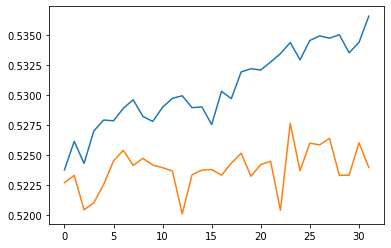

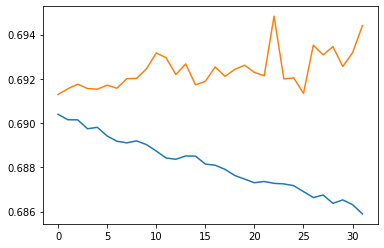

In [21]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=32,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## 100 epocas

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=32,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Epoch 1/32
7997/7997 [==============================] - 38s 5ms/step - loss: 0.6916 - accuracy: 0.5206 - val_loss: 0.6915 - val_accuracy: 0.5229
Epoch 2/32
7997/7997 [==============================] - 37s 5ms/step - loss: 0.6913 - accuracy: 0.5209 - val_loss: 0.6918 - val_accuracy: 0.5220
Epoch 3/32
7997/7997 [==============================] - 38s 5ms/step - loss: 0.6912 - accuracy: 0.5222 - val_loss: 0.6913 - val_accuracy: 0.5201
Epoch 4/32
1783/7997 [=====>........................] - ETA: 25s - loss: 0.6912 - accuracy: 0.5220

## 32 epocas

Epoch 1/32
10092/10092 [==============================] - 45s 4ms/step - loss: 0.6912 - accuracy: 0.5208 - val_loss: 0.6905 - val_accuracy: 0.3636
Epoch 2/32
10092/10092 [==============================] - 45s 4ms/step - loss: 0.6911 - accuracy: 0.5218 - val_loss: 0.6887 - val_accuracy: 0.4242
Epoch 3/32
10092/10092 [==============================] - 45s 4ms/step - loss: 0.6910 - accuracy: 0.5217 - val_loss: 0.6802 - val_accuracy: 0.4545
Epoch 4/32
10092/10092 [==============================] - 46s 5ms/step - loss: 0.6909 - accuracy: 0.5230 - val_loss: 0.6926 - val_accuracy: 0.3788
Epoch 5/32
10092/10092 [==============================] - 45s 4ms/step - loss: 0.6907 - accuracy: 0.5237 - val_loss: 0.6846 - val_accuracy: 0.6515
Epoch 6/32
10092/10092 [==============================] - 45s 4ms/step - loss: 0.6906 - accuracy: 0.5245 - val_loss: 0.6871 - val_accuracy: 0.4091
Epoch 7/32
10092/10092 [==============================] - 45s 4ms/step - loss: 0.6905 - accuracy: 0.5238 - val_loss: 0

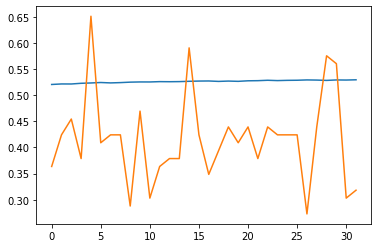

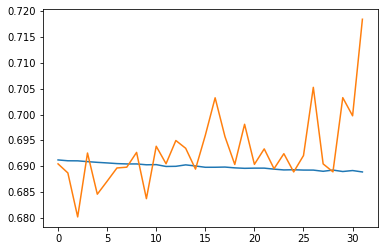

In [27]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=32,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Epoch 1/100
8075/8075 [==============================] - 36s 4ms/step - loss: 0.6889 - accuracy: 0.5302 - val_loss: 0.7032 - val_accuracy: 0.3182
Epoch 2/100
8075/8075 [==============================] - 36s 4ms/step - loss: 0.6886 - accuracy: 0.5320 - val_loss: 0.7086 - val_accuracy: 0.3485
Epoch 3/100
8075/8075 [==============================] - 36s 4ms/step - loss: 0.6887 - accuracy: 0.5314 - val_loss: 0.6974 - val_accuracy: 0.3788
Epoch 4/100
8075/8075 [==============================] - 36s 4ms/step - loss: 0.6884 - accuracy: 0.5320 - val_loss: 0.7162 - val_accuracy: 0.3030
Epoch 5/100
8075/8075 [==============================] - 35s 4ms/step - loss: 0.6887 - accuracy: 0.5312 - val_loss: 0.7150 - val_accuracy: 0.3182
Epoch 6/100
8075/8075 [==============================] - 36s 4ms/step - loss: 0.6886 - accuracy: 0.5311 - val_loss: 0.7048 - val_accuracy: 0.3182
Epoch 7/100
8075/8075 [==============================] - 37s 5ms/step - loss: 0.6885 - accuracy: 0.5318 - val_loss: 0.7015 -

Epoch 57/100
8075/8075 [==============================] - 34s 4ms/step - loss: 0.6872 - accuracy: 0.5320 - val_loss: 0.6891 - val_accuracy: 0.3939
Epoch 58/100
8075/8075 [==============================] - 38s 5ms/step - loss: 0.6873 - accuracy: 0.5331 - val_loss: 0.6906 - val_accuracy: 0.4242
Epoch 59/100
8075/8075 [==============================] - 37s 5ms/step - loss: 0.6870 - accuracy: 0.5334 - val_loss: 0.7019 - val_accuracy: 0.5455
Epoch 60/100
8075/8075 [==============================] - 37s 5ms/step - loss: 0.6871 - accuracy: 0.5335 - val_loss: 0.6812 - val_accuracy: 0.6667
Epoch 61/100
8075/8075 [==============================] - 37s 5ms/step - loss: 0.6868 - accuracy: 0.5333 - val_loss: 0.6914 - val_accuracy: 0.4091
Epoch 62/100
8075/8075 [==============================] - 37s 5ms/step - loss: 0.6867 - accuracy: 0.5342 - val_loss: 0.7043 - val_accuracy: 0.3485
Epoch 63/100
8075/8075 [==============================] - 37s 5ms/step - loss: 0.6871 - accuracy: 0.5324 - val_loss: 0

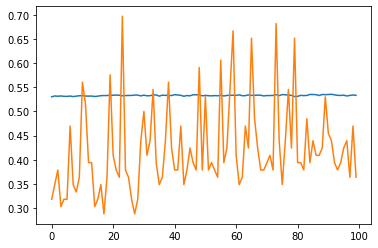

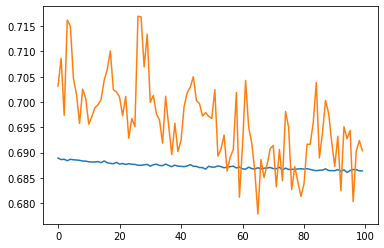

In [37]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Sin OHLC

## 16 epocas

Epoch 1/16
10092/10092 [==============================] - 45s 4ms/step - loss: 0.6933 - accuracy: 0.5089 - val_loss: 0.6973 - val_accuracy: 0.3182
Epoch 2/16
10092/10092 [==============================] - 47s 5ms/step - loss: 0.6928 - accuracy: 0.5108 - val_loss: 0.7034 - val_accuracy: 0.3182
Epoch 3/16
10092/10092 [==============================] - 46s 5ms/step - loss: 0.6926 - accuracy: 0.5126 - val_loss: 0.6933 - val_accuracy: 0.5606
Epoch 4/16
10092/10092 [==============================] - 46s 5ms/step - loss: 0.6925 - accuracy: 0.5138 - val_loss: 0.6911 - val_accuracy: 0.4242
Epoch 5/16
10092/10092 [==============================] - 47s 5ms/step - loss: 0.6923 - accuracy: 0.5128 - val_loss: 0.6998 - val_accuracy: 0.3182
Epoch 6/16
10092/10092 [==============================] - 46s 5ms/step - loss: 0.6922 - accuracy: 0.5153 - val_loss: 0.6936 - val_accuracy: 0.3182
Epoch 7/16
10092/10092 [==============================] - 45s 4ms/step - loss: 0.6922 - accuracy: 0.5157 - val_loss: 0

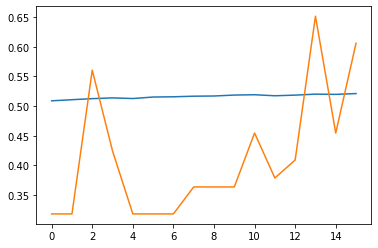

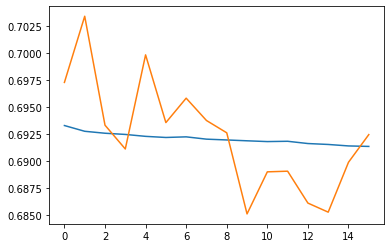

In [26]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
    validation_data=(x_test, y_test)
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [38]:
model.save('./models/model_100_ephocs.h5')

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train = full_df.drop(columns='target')
y_train = full_df['target']

In [36]:
len(x_train)

322997

In [35]:
y_train

0         1.0
1         1.0
2         1.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         1.0
9         1.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        1.0
24        0.0
25        0.0
26        0.0
27        1.0
28        1.0
29        1.0
         ... 
322967    0.0
322968    0.0
322969    0.0
322970    1.0
322971    1.0
322972    1.0
322973    1.0
322974    1.0
322975    1.0
322976    1.0
322977    1.0
322978    1.0
322979    0.0
322980    1.0
322981    1.0
322982    1.0
322983    1.0
322984    1.0
322985    0.0
322986    0.0
322987    0.0
322988    1.0
322989    0.0
322990    1.0
322991    0.0
322992    0.0
322993    0.0
322994    0.0
322995    0.0
322996    1.0
Name: target, Length: 322997, dtype: float64

Epoch 1/16
10094/10094 [==============================] - 40s 4ms/step - loss: 5.0090 - accuracy: 0.5046
Epoch 2/16
10094/10094 [==============================] - 44s 4ms/step - loss: 0.6956 - accuracy: 0.5043
Epoch 3/16
10094/10094 [==============================] - 40s 4ms/step - loss: 0.6947 - accuracy: 0.5047
Epoch 4/16
10094/10094 [==============================] - 45s 4ms/step - loss: 0.6950 - accuracy: 0.5046
Epoch 5/16
10094/10094 [==============================] - 41s 4ms/step - loss: 0.6940 - accuracy: 0.5047
Epoch 6/16
10094/10094 [==============================] - 40s 4ms/step - loss: 0.6956 - accuracy: 0.5051
Epoch 7/16
10094/10094 [==============================] - 43s 4ms/step - loss: 0.6937 - accuracy: 0.5048
Epoch 8/16
10094/10094 [==============================] - 45s 4ms/step - loss: 0.6940 - accuracy: 0.5049
Epoch 9/16
10094/10094 [==============================] - 46s 5ms/step - loss: 0.6938 - accuracy: 0.5049
Epoch 10/16
10094/10094 [==============================

KeyError: 'val_accuracy'

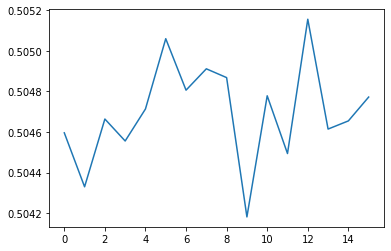

In [37]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [39]:
model.save('./model_16_ephocs.h5')

In [32]:
full_df = pd.read_csv('./data/processed/full_df.csv')

In [33]:
train, test = train_test_split(full_df, train_size=0.8, random_state=42)
del full_df

In [34]:
train.drop(columns=['open','high','low','close'], inplace=True)
test.drop(columns=['open','high','low','close'], inplace=True)
train.head(4)

percentage_price_change  hour  day  day_of_week  week  month  quarter  \
268375                -0.108317     8    7            0    45     11        4   
240343                -0.028838    18   11            4    19      5        2   
306918                -0.057523     6   19            4     3      1        1   
80949                 -0.053049     1   28            3    17      4        2   

        year  discrete_rsi  discrete_ema12_ema26  discrete_ema_12  \
268375  2011            -1                    -1               -1   
240343  2007             0                     1                1   
306918  2018             0                     1                1   
80949   2016             0                     1               -1   

        discrete_ema_26  discrete_bollinger_bands  discrete_macd_signal  \
268375               -1                         0                     0   
240343                1                         0                     1   
306918                1                         0                     1   
80949                -1                         0                     1   

        discrete_macd_hist  discrete_macd_hist_signal  \
268375                   0                          1   
240343                   0                          0   
306918                   0                          0   
80949                    0                          0   

        percentage_price_change_shifted_1  percentage_price_change_shifted_2  \
268375                          -0.026290                          -0.195537   
240343                           0.033655                          -0.033644   
306918                          -0.067544                          -0.031606   
80949                           -0.143908                          -0.003531   

        percentage_price_change_shifted_3  percentage_price_change_shifted_4  \
268375                           0.033121                          -0.050593   
240343                           0.002403                           0.021634   
306918                           0.181347                          -0.005757   
80949                            0.018543                           0.020313   

        percentage_price_change_shifted_5  discrete_rsi_shifted_1  \
268375                          -0.082381                    -1.0   
240343                          -0.024032                     0.0   
306918                           0.016553                     0.0   
80949                            0.087511                     0.0   

        discrete_rsi_shifted_2  discrete_rsi_shifted_3  \
268375                    -1.0                    -1.0   
240343                     0.0                     0.0   
306918                     0.0                     0.0   
80949                      0.0                     0.0   

        discrete_rsi_shifted_4  discrete_rsi_shifted_5  \
268375                    -1.0                    -1.0   
240343                     0.0                     0.0   
306918                     0.0                     0.0   
80949                      0.0                     0.0   

        discrete_ema12_ema26_Shifted_1  discrete_ema12_ema26_Shifted_2  \
268375                            -1.0                            -1.0   
240343                             1.0                             1.0   
306918                             1.0                             1.0   
80949                              1.0                             1.0   

        discrete_ema12_ema26_Shifted_3  discrete_ema12_ema26_Shifted_4  \
268375                            -1.0                            -1.0   
240343                             1.0                             1.0   
306918                             1.0                             1.0   
80949                              1.0                             1.0   

        discrete_ema12_ema26_Shifted_5  discrete_ema_12_shifted_1  \
268375                            -1.0               

In [35]:
len(train.columns)

60

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train = train.drop(columns='target')
y_train = train['target']

scaled_features = scaler.fit_transform(x_train)
x_train = pd.DataFrame(scaled_features, index=x_train.index, columns=x_train.columns)

x_test = test.drop(columns='target')
y_test = test['target']

scaled_features = scaler.fit_transform(x_test)
x_test = pd.DataFrame(scaled_features, index=x_test.index, columns=x_test.columns)

In [49]:
df = pd.DataFrame(data={'a': [1,2,3,4,5,6]})

In [51]:
x = 'asd'
df['b'] = 1 if x == 'asd' else 0
df

a  b
0  1  1
1  2  1
2  3  1
3  4  1
4  5  1
5  6  1

In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
df

a    b
0  0.0  0.0
1  0.2  0.0
2  0.4  0.0
3  0.6  0.0
4  0.8  0.0
5  1.0  0.0